In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.utils import Sequence
from keras.applications import EfficientNetV2B0

In [2]:
# Importing the scans from processed_scans folder, 
fileNames = []

# Create an array of all the file names from the processed_scans folder
for root, dirs, files in os.walk('processed_scans'):
	for file in files:
		fileNames.append(file)

# Importing the labels from the csv file
labels = pd.read_csv('oasis_cross-sectional.csv', dtype=str)

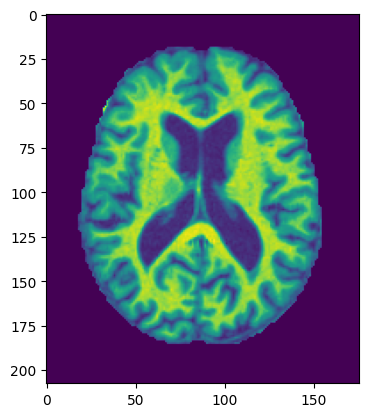

OAS1_0001_MR1.gif
              ID M/F Hand Age Educ SES MMSE CDR  eTIV   nWBV    ASF Delay
0  OAS1_0001_MR1   F    R  74    2   3   29   0  1344  0.743  1.306   NaN


In [3]:
# Display the first image and the label for it
plt.imshow(plt.imread('processed_scans/'+fileNames[0]))
plt.show()
print(fileNames[0])
print(labels[0:1])


In [4]:
image_data = []

for fileName in fileNames:
    img = load_img('processed_scans/'+fileName, target_size=(224, 224, 3))
    img_array = img_to_array(img)
    image_data.append(img_array)

image_data = np.array(image_data)


In [5]:
# Checking to see if there's a corresponding label for each image
checkedLabels = labels[labels['ID'].isin([fileName[:13] for fileName in fileNames])]



In [6]:
directory='/processed_scans/'

def createFileName(id):
	return directory + id + ".png"

# Create a new column in the labels dataframe that contains the file name
checkedLabels['fileNames'] = checkedLabels['ID'].apply(createFileName)

# CDR can be '0.0', '0.5', 'nan', '1.0', '2.0'
# As this is not a scale, but more of a classification, this can be passed as a string, then tokenized
def convertToString(cdr):
	if str(cdr) == 'nan':
		return '0'
	else:
		return str(cdr)

# Convert the CDR column to a float (if it's nan, it will be converted to 0)
checkedLabels['CDR'] = checkedLabels['CDR'].apply(convertToString)

# Creating Age_scaled column
checkedLabels['Age_scaled'] = checkedLabels['Age'].apply(lambda x: float(x) / float(checkedLabels['Age'].max()))

# Creating MMSE_scaled column

def mmseConvert(x):
	if math.isnan(float(x)):
		return np.random.randint(25, 30)
	else:
		return x

checkedLabels['MMSE'] = checkedLabels['MMSE'].apply(mmseConvert)



C:\Users\mlg\AppData\Local\Temp\ipykernel_23296\1548321930.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkedLabels['fileNames'] = checkedLabels['ID'].apply(createFileName)
C:\Users\mlg\AppData\Local\Temp\ipykernel_23296\1548321930.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkedLabels['CDR'] = checkedLabels['CDR'].apply(convertToString)
C:\Users\mlg\AppData\Local\Temp\ipykernel_23296\1548321930.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [7]:
# Print all the unique values in the CDR column
print(checkedLabels['CDR'].unique())
print(checkedLabels['MMSE'].unique())
print(checkedLabels[[ 'M/F', 'Age', 'Educ', 'MMSE']].isna().sum())

['0' '0.5' '1' '2']
['29' '27' 26 27 29 28 '30' 25 '28' '23' '26' '22' '21' '15' '25' '18'
 '24' '20' '16' '17' '19' '14']
M/F       0
Age       0
Educ    201
MMSE      0
dtype: int64


In [8]:
train_datagen = ImageDataGenerator(rescale=1/255,
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    height_shift_range=0.05,
    width_shift_range=0.05,
    shear_range=0.08,
    zoom_range=0.08,
    horizontal_flip=True,
    vertical_flip=False,
)


In [9]:
# https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3 For help
class CustomGenerator(Sequence):
	def __init__(self, df, datagen, batch_size, target_size):
		self.df = df
		self.datagen = datagen
		self.batch_size = batch_size
		self.target_size = target_size
			
	def __len__(self):
		return int(np.ceil(len(self.df) / self.batch_size))
	
	def on_epoch_end(self):
		pass
	
	def __getitem__(self, idx):

		# If the batch size is not a multiple of the total number of images, the last batch will be smaller
		batchEnd = (idx+1)*self.batch_size if (idx+1)*self.batch_size < len(self.df) else len(self.df)

		#print(f"batch: {idx*self.batch_size} {batchEnd}, idx: {idx}")

		# Get the batch
		batch = self.df[idx*self.batch_size:batchEnd]

		# Create the arrays to store the images and labels
		batch_x = np.zeros((len(batch),) + self.target_size + (3,), dtype='float32')
		batch_y = np.zeros((len(batch),), dtype='int32')

		# Create the arrays to store the attributes
		batch_a = np.zeros((len(batch), 4), dtype='float32')
		
		for i, row in batch.iterrows():
			try:
				# i refers to the index of the dataframe, not the batch
				currentIndex = i % self.batch_size - 1

				#print(f"i: {i}, currentIndex: {currentIndex}, batchEnd: {batchEnd}, batchStart: {idx*self.batch_size}")

				img = tf.keras.preprocessing.image.load_img(
					row['fileNames'],
					target_size=self.target_size
				)
				x = tf.keras.preprocessing.image.img_to_array(img)
				x = self.datagen.random_transform(x)
				x = self.datagen.standardize(x)

				batch_x[currentIndex] = x

				batch_y[currentIndex] = float(row['CDR'])
				batch_a[currentIndex, 0] = float(1 if row['M/F'] == 'M' else 0)
				batch_a[currentIndex, 1] = float(row['Age'])
				batch_a[currentIndex, 2] = float(row['MMSE'])
				batch_a[currentIndex, 3] = float(row['eTIV'])
			except Exception as e:
				print(f";( {e}")
			
		return ([batch_a, batch_x], batch_y)

	

In [10]:
# Setting the train/validation split
split = 0.8
splitIndex = int(len(checkedLabels) * split)

train_ds = CustomGenerator(
    checkedLabels[:splitIndex],
    train_datagen,
    batch_size=8,
    target_size=(224, 224)
)

val_ds = CustomGenerator(
    checkedLabels[splitIndex:],
    train_datagen,
    batch_size=8,
    target_size=(224, 224)
)

M/F (0 = F, 1 = M): 0.0, Age:55.0, MMSE Score:29.0
CDR: 0


c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


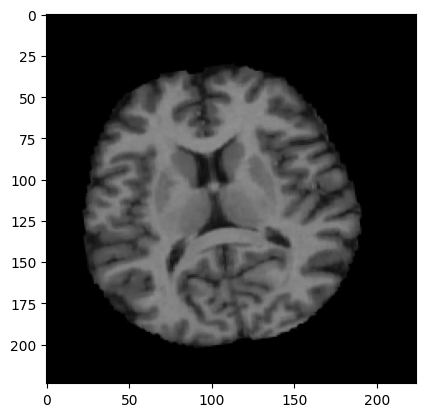

In [11]:
# Getting a batch from the generator
sample = train_ds.__getitem__(0)

# Selecting the first image from the batch
img = sample[0][1][0]

# getting the image attributes
attributes = sample[0][0][0]
print(f"M/F (0 = F, 1 = M): {attributes[0]}, Age:{attributes[1]}, MMSE Score:{attributes[2]}")

# getting the CDR value
print(f"CDR: {sample[1][0]}")

# Plotting the image
plt.imshow(img)


In [12]:
# Creating a sub-model to be concatenated with the main model, with age/gender/education/MMSE as input

sub_model_input = Input(shape=(4,))

x = Dense(64, activation='relu')(sub_model_input)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

sub_model_output = Dense(64, activation='relu')(x)

sub_model = Model(inputs=sub_model_input, outputs=sub_model_output)


In [13]:
# Here I'm using the MobileNetV2 model for testing purposes as it is a lightweight model
preTrainedModel = EfficientNetV2B0(
	input_shape=(224, 224, 3),
	include_top=False,
)

for _ in range(3):
	preTrainedModel.layers.pop()

# Freezing the layers of the model so that they don't get trained (apart from the last 10)
# This should help the training to not override the feature extraction layers
for layer in preTrainedModel.layers[:-5]:
	layer.trainable = False

24274472/24274472 [==============================] - 9s 0us/step


In [14]:


inputs = Input(shape=(224, 224, 3))
x = preTrainedModel(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Concatenate()([sub_model.output, x])
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=[sub_model_input, inputs], outputs=outputs)

# The summary of the model is shown, this is to check if the model is being built correctly
model.summary()

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.000001),
	loss='sparse_categorical_crossentropy',
	metrics=['accuracy']
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense (Dense)                  (None, 64)           320         ['input_1[0][0]']                
                                                                                                  
 efficientnetv2-b0 (Functional)  (None, 7, 7, 1280)  5919312     ['input_3[0][0]']          

Epoch 1/400
44/44 [==============================] - 13s 109ms/step - loss: 8.6828 - accuracy: 0.4971 - val_loss: 1.2436 - val_accuracy: 0.9195
Epoch 2/400
44/44 [==============================] - 3s 74ms/step - loss: 7.3645 - accuracy: 0.5575 - val_loss: 1.3539 - val_accuracy: 0.9195
Epoch 3/400
44/44 [==============================] - 3s 73ms/step - loss: 7.6168 - accuracy: 0.5431 - val_loss: 1.4762 - val_accuracy: 0.9195
Epoch 4/400
44/44 [==============================] - 3s 73ms/step - loss: 6.6916 - accuracy: 0.5833 - val_loss: 1.5772 - val_accuracy: 0.9195
Epoch 5/400
44/44 [==============================] - 3s 75ms/step - loss: 5.4572 - accuracy: 0.6351 - val_loss: 1.6679 - val_accuracy: 0.9195
Epoch 6/400
44/44 [==============================] - 3s 73ms/step - loss: 5.5209 - accuracy: 0.6408 - val_loss: 1.7399 - val_accuracy: 0.9195
Epoch 7/400
44/44 [==============================] - 3s 75ms/step - loss: 4.9176 - accuracy: 0.6695 - val_loss: 1.8144 - val_accuracy: 0.9195
Epoc

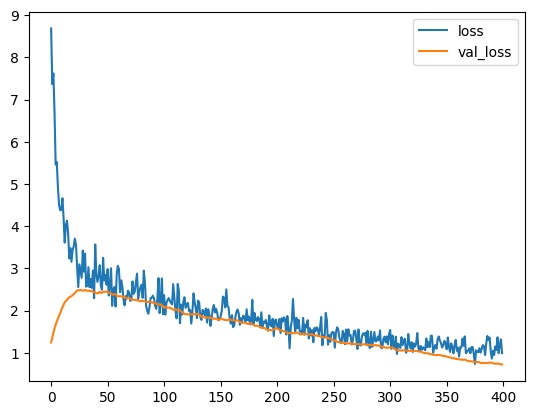

In [15]:
# Fit the model to the training data
history = model.fit(
	x=train_ds,
	epochs=400,
	validation_data=val_ds,
	batch_size=8,
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [16]:
# Unfreeze all the layers of the model
for layer in model.layers:
	layer.trainable = True

# Compile the model again, with a slower learning rate

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.00000001),
	loss='sparse_categorical_crossentropy',
	metrics=['accuracy']
)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense (Dense)                  (None, 64)           320         ['input_1[0][0]']                
                                                                                                  
 efficientnetv2-b0 (Functional)  (None, 7, 7, 1280)  5919312     ['input_3[0][0]']          

Epoch 1/800
44/44 [==============================] - 14s 140ms/step - loss: 1.2395 - accuracy: 0.7960 - val_loss: 0.8024 - val_accuracy: 0.9195
Epoch 2/800
44/44 [==============================] - 5s 105ms/step - loss: 1.5605 - accuracy: 0.7931 - val_loss: 0.8469 - val_accuracy: 0.9195
Epoch 3/800
44/44 [==============================] - 5s 104ms/step - loss: 1.5180 - accuracy: 0.7960 - val_loss: 0.8430 - val_accuracy: 0.9195
Epoch 4/800
44/44 [==============================] - 5s 105ms/step - loss: 1.3332 - accuracy: 0.8132 - val_loss: 0.8867 - val_accuracy: 0.9195
Epoch 5/800
44/44 [==============================] - 5s 105ms/step - loss: 1.2466 - accuracy: 0.8132 - val_loss: 0.8405 - val_accuracy: 0.9195
Epoch 6/800
44/44 [==============================] - 5s 105ms/step - loss: 1.5170 - accuracy: 0.8075 - val_loss: 0.8248 - val_accuracy: 0.9195
Epoch 7/800
44/44 [==============================] - 5s 104ms/step - loss: 1.4604 - accuracy: 0.7960 - val_loss: 0.8105 - val_accuracy: 0.919

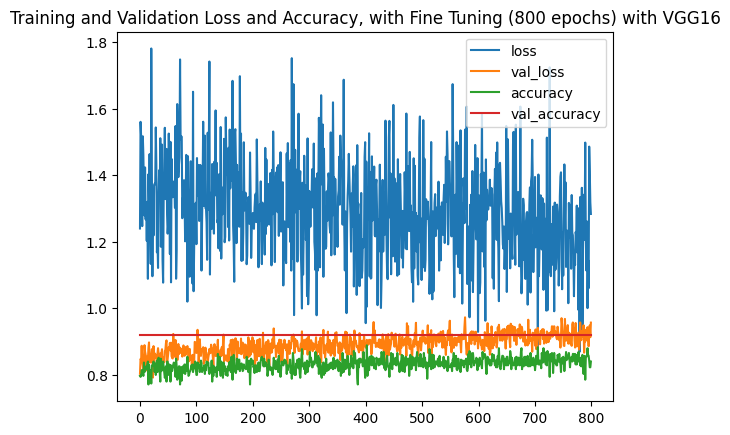

In [17]:
# Fit the model to the training data
fine_tuning_history = model.fit(
	x=train_ds,
	epochs=800,
	validation_data=val_ds,
	batch_size=8,
)

# Plot the training and validation loss
plt.plot(fine_tuning_history.history['loss'], label='loss')
plt.plot(fine_tuning_history.history['val_loss'], label='val_loss')
plt.plot(fine_tuning_history.history['accuracy'], label='accuracy')
plt.plot(fine_tuning_history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Loss and Accuracy, with Fine Tuning (800 epochs) with VGG16')
plt.legend()
plt.show()

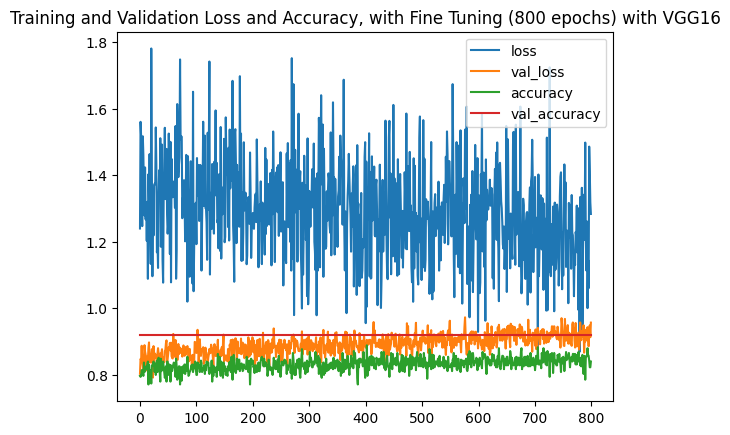

In [18]:
# Plot the training and validation loss
plt.plot(fine_tuning_history.history['loss'], label='loss')
plt.plot(fine_tuning_history.history['val_loss'], label='val_loss')
plt.plot(fine_tuning_history.history['accuracy'], label='accuracy')
plt.plot(fine_tuning_history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Loss and Accuracy, with Fine Tuning (800 epochs) with EfficientNetV2B0')
plt.legend()
plt.show()

In [19]:
# Fit the model to the training data
fine_tuning_history2 = model.fit(
	x=train_ds,
	epochs=800,
	validation_data=val_ds,
	batch_size=8,
)

# Plot the training and validation loss
plt.plot(fine_tuning_history2.history['loss'], label='loss')
plt.plot(fine_tuning_history2.history['val_loss'], label='val_loss')
plt.plot(fine_tuning_history2.history['accuracy'], label='accuracy')
plt.plot(fine_tuning_history2.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

Epoch 1/800
44/44 [==============================] - 5s 107ms/step - loss: 1.3837 - accuracy: 0.8391 - val_loss: 0.9267 - val_accuracy: 0.9195
Epoch 2/800
44/44 [==============================] - 5s 105ms/step - loss: 1.3598 - accuracy: 0.8276 - val_loss: 0.9053 - val_accuracy: 0.9195
Epoch 3/800
44/44 [==============================] - 5s 105ms/step - loss: 1.1532 - accuracy: 0.8218 - val_loss: 0.8937 - val_accuracy: 0.9195
Epoch 4/800
44/44 [==============================] - 5s 104ms/step - loss: 1.1802 - accuracy: 0.8592 - val_loss: 0.9252 - val_accuracy: 0.9195
Epoch 5/800
44/44 [==============================] - 5s 105ms/step - loss: 1.1626 - accuracy: 0.8333 - val_loss: 0.9467 - val_accuracy: 0.9195
Epoch 6/800
44/44 [==============================] - 5s 104ms/step - loss: 1.3739 - accuracy: 0.8190 - val_loss: 0.9528 - val_accuracy: 0.9195
Epoch 7/800
44/44 [==============================] - 5s 105ms/step - loss: 1.2686 - accuracy: 0.8477 - val_loss: 0.9496 - val_accuracy: 0.9195

KeyboardInterrupt: 

In [ ]:
# Fit the model to the training data
fine_tuning_history3 = model.fit(
	x=train_ds,
	epochs=800,
	validation_data=val_ds,
	batch_size=8,
)

# Plot the training and validation loss
plt.plot(fine_tuning_history3.history['loss'], label='loss')
plt.plot(fine_tuning_history3.history['val_loss'], label='val_loss')
plt.plot(fine_tuning_history3.history['accuracy'], label='accuracy')
plt.plot(fine_tuning_history3.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# Fit the model to the training data
fine_tuning_history4 = model.fit(
	x=train_ds,
	epochs=800,
	validation_data=val_ds,
	batch_size=8,
)

# Plot the training and validation loss
plt.plot(fine_tuning_history4.history['loss'], label='loss')
plt.plot(fine_tuning_history4.history['val_loss'], label='val_loss')
plt.plot(fine_tuning_history4.history['accuracy'], label='accuracy')
plt.plot(fine_tuning_history4.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()